# Demo Script for Milestone 10.15

## 0 Prepare task

### 0.1 prepare planning scene

In [1]:
import os
import sys
sys.path.append(os.path.join(os.path.join(os.environ["RNB_PLANNING_DIR"], 'src')))
sys.path.append(os.path.join(os.environ["RNB_PLANNING_DIR"], 'src/scripts/milestone_202110'))

from pkg.global_config import RNB_PLANNING_DIR
from demo_utils.kiro_udp_send import start_mobile_udp_thread, send_pose_wait, get_xyzw_cur, get_reach_state
from pkg.utils.utils import *    
from pkg.utils.rotation_utils import *
from pkg.controller.combined_robot import *
from pkg.project_config import *
from demo_utils.streaming import *
from demo_utils.detect_table import *
from demo_utils.area_select import *
from pkg.detector.aruco.marker_config import get_aruco_map
aruco_map = get_aruco_map()


CONNECT_CAM = True # True
ENABLE_DETECT = True
# DETECT_MARKER = True
CONNECT_INDY = True # True
CONNECT_MOBILE = True # True 

# Tool dimensions
TOOL_DIM = [0.32, 0.08]
TOOL_OFFSET = 0.0
ROBOT_Z_ANGLE = np.pi
MARGIN = 0
TRACK_THICKNESS = 0.001

INDY_BASE_OFFSET = (0.172,0,0.439)
ROBOT_Z_ANGLE = np.pi
TOOL_NAME = "brush_face"
WALL_THICKNESS = 0.01
CLEARANCE = 0.001

ip_cur = "192.168.0.7"# get_ip_address()
MOBILE_IP = "192.168.0.102"
INDY_IP = "192.168.0.3"
CAM_HOST = '192.168.0.10'

print("Current PC IP: {}".format(ip_cur))
print("Mobile ROB IP: {}".format(MOBILE_IP))
print("CAM SERVER IP: {}".format(CAM_HOST))

from pkg.geometry.builder.scene_builder import SceneBuilder
from demo_utils.environment import *

from utils.streaming import *
from utils.detection_util import *

if CONNECT_MOBILE:
    sock_mobile, server_thread = start_mobile_udp_thread(recv_ip=ip_cur)
    time.sleep(1)

mobile_config = RobotConfig(0, RobotType.kmb, ((0,0,0), (0,0,0)),
                MOBILE_IP)
robot_config = RobotConfig(1, RobotType.indy7, (INDY_BASE_OFFSET, (0,0,np.pi)),
                INDY_IP, root_on="kmb0_platform", 
                           specs={"no_sdk":True})
MOBILE_NAME = mobile_config.get_indexed_name()
ROBOT_NAME = robot_config.get_indexed_name()
crob = CombinedRobot(robots_on_scene=[mobile_config, robot_config]
              , connection_list=[False, CONNECT_INDY])

s_builder = SceneBuilder(None)
gscene = s_builder.create_gscene(crob)

gtems = s_builder.add_robot_geometries(color=(0,1,0,0.5), display=True, collision=True)
gscene.set_workspace_boundary(-3, 7, -5, 5, -CLEARANCE, 3, thickness=WALL_THICKNESS)


from pkg.planning.scene import PlanningScene
pscene = PlanningScene(gscene, combined_robot=crob)

ROBOT_BASE = pscene.robot_chain_dict[ROBOT_NAME]['link_names'][0]
TIP_LINK = pscene.robot_chain_dict[ROBOT_NAME]["tip_link"]
MOBILE_BASE = pscene.robot_chain_dict[MOBILE_NAME]["tip_link"]
HOLD_LINK = MOBILE_BASE

viewpoint = add_cam(gscene, tool_link=TIP_LINK)
# add_indy_tool_kiro(gscene, tool_link=TIP_LINK, face_name=TOOL_NAME, zoff=TOOL_OFFSET)

HOME_POSE = -crob.home_pose
HOME_DICT = list2dict(HOME_POSE, gscene.joint_names)

from pkg.planning.pipeline import PlanningPipeline
ppline = PlanningPipeline(pscene)

# Set planner
from pkg.planning.motion.moveit.moveit_planner import MoveitPlanner
from pkg.planning.filtering.grasp_filter import GraspChecker
mplan = MoveitPlanner(pscene, enable_dual=False, incremental_constraint_motion=True)
mplan.motion_filters = [GraspChecker(pscene)]
mplan.update_gscene()
from pkg.planning.task.rrt import TaskRRT
tplan = TaskRRT(pscene)
tplan.prepare()
ppline.set_motion_planner(mplan)
ppline.set_task_planner(tplan)

from pkg.ui.ui_broker import *

# start UI
ui_broker = UIBroker.instance()
ui_broker.initialize(ppline, s_builder)
ui_broker.start_server()

ui_broker.set_tables()

add_kiro_indytool_down(gscene, zoff=TOOL_OFFSET, tool_link=TIP_LINK, face_name=TOOL_NAME)

# Register binders
from pkg.planning.constraint.constraint_actor import VacuumTool, Gripper2Tool, PlacePlane, SweepFramer, WayFramer
brush_face = pscene.create_binder(bname=TOOL_NAME, gname=TOOL_NAME, _type=SweepFramer, 
                                  point=(-gscene.NAME_DICT['brush_face'].dims[0]/2-CLEARANCE,0,0), 
                                  rpy=(0,np.pi/2*1,0))

# waypoint
WP_DIMS = (0.6,0.4,WALL_THICKNESS)
gscene.create_safe(gtype=GEOTYPE.BOX, name="wayframer", link_name=HOLD_LINK,
                   dims=WP_DIMS, center=(0,0,WP_DIMS[2]/2), rpy=(0,0,0), color=(1, 0, 0, 0.5), display=True,
                   collision=False, fixed=True)
wayframer = pscene.create_binder(bname="wayframer", gname="wayframer", _type=WayFramer, 
                                 point=(0,0,-WP_DIMS[2]/2-CLEARANCE), rpy=(0,0,0))

indy = crob.robot_dict["indy1"]

Current PC IP: 192.168.0.7
Mobile ROB IP: 192.168.0.102
CAM SERVER IP: 192.168.0.10
[MOBILE ROBOT] bind: ('192.168.0.7', 50306)
[MOBILE ROBOT] Start UDP THREAD
connection command:
kmb0: False
indy1: True
Connect: Server IP (192.168.0.3)
Unable to register with master node [http://localhost:11311]: master may not be running yet. Will keep trying.
Please create a subscriber to the marker
publication OK
published: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Please create a subscriber to the marker
Dash is running on http://0.0.0.0:8050/

 * Serving Flask app "pkg.ui.dash_launcher" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


### 0.2 Wait task start queue

## 1. Bed cleaning

### 1.1 Detect bed

#### 1.1.1 Move to bed-seek pose 

In [2]:
VIEW_POSE = np.deg2rad([  0., -50.,  70.,  -0.,  90., -180])
VIEW_LOC = [0,]*6
VIEW_POSE_EXT = np.array(VIEW_LOC + list(VIEW_POSE))
if CONNECT_INDY:
    with indy:
        indy.joint_move_to(np.rad2deg(VIEW_POSE))
        time.sleep(0.5)
        indy.wait_for_move_finish()
        Qcur = np.deg2rad(indy.get_joint_pos())
else:
    Qcur = VIEW_POSE
gscene.show_pose(VIEW_POSE_EXT)

Connect: Server IP (192.168.0.3)
Move finished!


* **[TODO] rotate until bed is detected**

In [3]:
if ENABLE_DETECT:
    attacth_to_server()

In [4]:
# CAM_HOST = '192.168.0.40'
if CONNECT_CAM:
    # rdict = send_recv_demo_cam({1:1}, host=CAM_HOST)
    rdict = stream_capture_image(ImageType.FirstView, obj_type="bed", host=CAM_HOST)
    cam_intrins, d_scale = [rdict[key] for key in ["intrins", "depth_scale"]]
    set_cam_params(cam_intrins, d_scale)
    bed_color_path = SAVE_DIR + '/bed.jpg'
    bed_depth_path = SAVE_DIR + '/bed.png'
else:
    cam_intrins = [1280, 720, 899.05322265625,  899.21044921875, 654.8836669921875, 352.9295654296875]
    d_scale = 0.0002500000118743628
    set_cam_params(cam_intrins, d_scale)
    bed_color_path = EXP_IMG_DIR + '/bed.jpg'
    bed_depth_path = EXP_IMG_DIR + '/bed.png'
#     bed_color_path = EXP_IMG_DIR + '/513.jpg'
#     bed_depth_path = EXP_IMG_DIR + '/top_table_0024.png'

# Read color, depth image file, keep 16bit information
color_img_read = cv2.imread(bed_color_path, flags=cv2.IMREAD_UNCHANGED)
depth_img_read = cv2.imread(bed_depth_path, flags=cv2.IMREAD_UNCHANGED)

# Output of inference(mask for detected table)
mask_out = detect_from_server(color_img_read)

# If bed is not detected, then pass below detection part
test = np.empty((720,1280), dtype=bool)
test[:,:] = False

In [5]:
while np.array_equal(mask_out, test):
    if CONNECT_INDY:
        with indy:
            Qnow = indy.get_joint_pos()
            Qto = np.add(Qnow, [10,0,0,0,0,0])
            Qto[0] = (Qto[0]+np.pi/2)%np.pi-np.pi/2
            indy.joint_move_to(Qto)
            indy.wait_motion()
    
    
    # Take a picture again after rotate
    time.sleep(1)
    rdict = stream_capture_image(ImageType.FirstView, obj_type="bed", host=CAM_HOST)
    
    # Read color, depth image file, keep 16bit information
    color_img_read = cv2.imread(bed_color_path, flags=cv2.IMREAD_UNCHANGED)
    depth_img_read = cv2.imread(bed_depth_path, flags=cv2.IMREAD_UNCHANGED)
    
    # Output of inference(mask for detected table)
    mask_out = detect_from_server(color_img_read)

#### 1.1.2  detect bed and add to the scene

:: Load two point clouds and disturb initial pose.
:: Downsample with a voxel size 0.050.
:: Estimate normal with search radius 0.100.
:: Compute FPFH feature with search radius 0.300.
:: Downsample with a voxel size 0.050.
:: Estimate normal with search radius 0.100.
:: Compute FPFH feature with search radius 0.300.
:: RANSAC registration on downsampled point clouds.
   Since the downsampling voxel size is 0.050,
   we use a liberal distance threshold 0.075.
[[-1.01381397  0.06702521  0.19870314 -0.16154649]
 [-0.13945801 -0.94809998 -0.39172947  0.45952208]
 [ 0.15661029 -0.4103756   0.93747489  2.84876721]
 [ 0.          0.          0.          1.        ]]
Apply point-to-point ICP
registration::RegistrationResult with fitness=4.088866e-01, inlier_rmse=3.340185e-02, and correspondence_set size of 21285
Access transformation to get result.
Transformation is:
[[-1.00968074 -0.02021471  0.22788213 -0.10320004]
 [-0.07446897 -0.9460235  -0.41386954  0.46240202]
 [ 0.21631752 -0.42002975

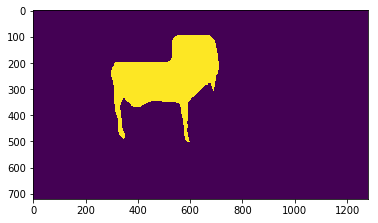

In [6]:
if not np.array_equal(mask_out, test):
    plt.imshow(mask_out)
    
    # Crop masking part
    vis_mask = (mask_out * 255).astype('uint8')
    color_instance = cv2.bitwise_and(color_img_read, color_img_read, mask=vis_mask).astype(np.uint16)
    depth_instance = cv2.bitwise_and(depth_img_read, depth_img_read, mask=vis_mask).astype(np.uint16)
    cv2.imwrite(CROP_DIR + '/bed_crop.jpg', color_instance)
    cv2.imwrite(CROP_DIR + '/bed_crop.png', depth_instance)
    
#     set_cam_params(cam_intrins, d_scale)
    ICP_result_bed = process_bed_detection(visualize=False)
    
T_toff_bed = np.identity(4)
T_toff_bed[:3,:3] = np.array([[0,1,0],[0,0,1],[1,0,0]])
T_toff_bed[:3,3] = np.array([0.455,0,1.05])

T_co = np.matmul(ICP_result_bed, T_toff_bed)
T_bc = viewpoint.get_tf(list2dict(VIEW_POSE_EXT, gscene.joint_names))
T_bo = np.matmul(T_bc, T_co)

In [7]:
bed_center = T_bo[:3,3]
bed_rpy = Rot2rpy(T_bo[:3,:3])

# bed_center = (2,0,0)
# bed_rpy = (0,0,np.pi/2)
COLOR_BED_COL = (0,1,0,0.3)

bed_mat = add_bed(gscene, bed_center, bed_rpy, COLOR_BED_COL)

In [8]:
T_revis = np.identity(4)
T_revis[:3,:3] = Rot_axis(3, Rot2axis(bed_mat.get_tf(VIEW_POSE_EXT)[:3,:3],3))
bed_rpy = Rot2rpy(T_revis[:3,:3])

# adjust
bed_center[2]=0
if Rot_rpy(bed_rpy)[0,0] > 0:
    bed_rpy[2] += np.pi

bed_mat = add_bed(gscene, bed_center, bed_rpy, COLOR_BED_COL)

# closet_leftup, closet_rightup, closet_down = add_closet(
#     gscene, closet_center=np.matmul(Rot_rpy(bed_rpy), (-0.75,-1.5,0))+bed_center, closet_rpy=bed_rpy, 
#     COLOR_CLOSET_COL=(0,1,0,0.3))

#### 1.1.3  move to closet side

In [9]:
bed_vis = gscene.NAME_DICT["bed_vis"]
T_bo = bed_vis.get_tf(list2dict(VIEW_POSE_EXT, gscene.joint_names))

In [10]:
if CONNECT_CAM:
    color_path = SAVE_DIR + '/bed.jpg'
    depth_path = SAVE_DIR + '/bed.png'
else:
    color_path = EXP_IMG_DIR + '/bed.jpg'
    depth_path = EXP_IMG_DIR + '/bed.png'

# Determine the location of closet
CLOSET_LOCATION = check_location_top_table(color_path, depth_path, T_bc, T_bo, bed_dims=bed_mat.dims, 
                                           visualize=False)
print("CLOSET on {}".format(CLOSET_LOCATION))

T_bm_from = wayframer.get_tf_handle(list2dict(VIEW_POSE_EXT, gscene.joint_names))
T_bs = bed_mat.get_tf(VIEW_POSE_EXT)

if CLOSET_LOCATION == "LEFT":
    T_sm = SE3(Rot_axis(3, np.pi), [1.5, -1.33, 0])
elif CLOSET_LOCATION == "RIGHT":       
    T_sm = SE3(Rot_axis(3, np.pi), [1.5, 1.33, 0])
    
T_bm = np.matmul(T_bs, T_sm)

x,y = T_bm[:2,3]
theta = Rot2axis(T_bm[:3,:3], 3)
VIEW_MOVED_EXT = np.add(VIEW_POSE_EXT, [x,y,theta]+[0]*9) 
gscene.show_pose(VIEW_MOVED_EXT)

CLOSET on LEFT


In [11]:
if CONNECT_MOBILE:
    VIEW_MOVED_EXT = move_mobile_update_state(sock_mobile, MOBILE_IP, wayframer, VIEW_POSE_EXT, VIEW_MOVED_EXT, 
                                              D_APPROACH=0)
gscene.show_pose(VIEW_MOVED_EXT)

move to VIEW_MOVED_EXT: [ 2.736  2.132 -0.222  0.     0.     0.     0.    -0.873  1.222  0.
  1.571 -3.142]
curre  xyzw: [ 0.57  0.74 -0.62  0.78]
ready  xyzw: [ 3.26 -1.46  0.71 -0.71]
target xyzw: [ 3.26 -1.46  0.71 -0.71]
move to: [ 3.26 -1.46  0.71 -0.71]
(3.2555404891604667, -1.4574079413745835, 0.7072270968173312, -0.7069864450803346, 0)
move to: [ 3.26 -1.46  0.71 -0.71]
(3.2555404891604667, -1.4574079413745835, 0.7072270968173312, -0.7069864450803346, 0)
(3.2555404891604667, -1.4574079413745835, 0.7072270968173312, -0.7069864450803346, 0)
(3.2555404891604667, -1.4574079413745835, 0.7072270968173312, -0.7069864450803346, 0)
stop at: [ 3.23 -1.41 -0.73  0.69]
ended in VIEW_MOVED_EXT: [ 2.682  2.117 -0.277  0.     0.     0.     0.    -0.873  1.222  0.
  1.571 -3.142]


#### 1.1.4  detect and add closet

In [12]:
if CONNECT_CAM:
    rdict = stream_capture_image(ImageType.FirstView, obj_type="closet", host=CAM_HOST)
    closet_color_path = SAVE_DIR + '/top_table.jpg'
    closet_depth_path = SAVE_DIR + '/top_table.png'
else:
    closet_color_path = EXP_IMG_DIR + '/top_table_0024.jpg'
    closet_depth_path = EXP_IMG_DIR + '/top_table_0024.png'
    
if CONNECT_CAM:
    Qdict_scan = list2dict(VIEW_MOVED_EXT, gscene.joint_names)
else:
    VIEW_POSE_MID = np.deg2rad([  0., -50.,  70.,  -0.,  75., -180])
    VIEW_MOVED_EXT[6:] = VIEW_POSE_MID
    Qdict_scan = list2dict(VIEW_MOVED_EXT, gscene.joint_names)
T_bc = viewpoint.get_tf(Qdict_scan)
T_bs = bed_vis.get_tf(Qdict_scan)
T_sc = np.matmul(SE3_inv(T_bs), T_bc)

ICP_result_top_table = process_top_table_detection(closet_color_path, closet_depth_path, T_sc=T_sc,
                                                   bed_dims=bed_mat.dims, z_ceiling = 2.3,
                                                   initial_offset=[0.3,1.1,0.6], floor_margin=0.1,
                                                   visualize=True)

T_toff_top_table = np.identity(4)
T_toff_top_table[:3,:3] = np.array([[1,0,0],[0,0,1],[0,-1,0]])
T_toff_top_table[:3,3] = np.array([0.3,0,0.2725])

T_co = np.matmul(ICP_result_top_table, T_toff_top_table)
T_bc = viewpoint.get_tf(list2dict(VIEW_MOVED_EXT, gscene.joint_names))
T_bo = np.matmul(T_bc, T_co)

closet_leftup, closet_rightup, closet_down = add_closet(
    gscene, closet_center=T_bo[:3,3], closet_rpy=Rot2rpy(T_bo[:3,:3]), 
    COLOR_CLOSET_COL=(0,1,0,0.3))

:: Load two point clouds and disturb initial pose.
:: Downsample with a voxel size 0.040.
:: Estimate normal with search radius 0.080.
:: Compute FPFH feature with search radius 0.240.
:: Downsample with a voxel size 0.040.
:: Estimate normal with search radius 0.080.
:: Compute FPFH feature with search radius 0.240.
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.340723e-01, inlier_rmse=2.467698e-02, and correspondence_set size of 11721
Access transformation to get result.
Transformation is:
[[-0.03112145 -0.03255163 -0.99898541  0.39898454]
 [ 0.38084914 -0.9244569   0.01825853  0.67434829]
 [-0.9241133  -0.37989451  0.0411677   2.99313759]
 [ 0.          0.          0.          1.        ]]


In [13]:

T_bo[:3,:3] = Rot_axis(3, Rot2axis(T_bo[:3,:3], 3))
T_bo[2,3] = 0

# if CONNECT_CAM:
# Add closet based on ICP result
closet_leftup, closet_rightup, closet_down = add_closet(
    gscene, closet_center=T_bo[:3,3], closet_rpy=Rot2rpy(T_bo[:3,:3]), 
    COLOR_CLOSET_COL=(0,1,0,0.3))
# else:
# closet_leftup, closet_rightup, closet_down = add_closet(
#     gscene, closet_center=np.matmul(Rot_rpy(bed_rpy), (-0.75,-1.5,0))+bed_center, closet_rpy=bed_rpy, 
#     COLOR_CLOSET_COL=(0,1,0,0.3))

### 1.2 Make bed cleaning plan

#### 1.2.1 get division-base pose combination data

In [14]:
from pkg.planning.constraint.constraint_common import *
from pkg.planning.constraint.constraint_actor import *
from pkg.planning.constraint.constraint_subject import *

In [15]:
gcheck = GraspChecker(pscene)
mplan.motion_filters = [gcheck]

wp_task, wp_hdl = add_waypoint_task(pscene, "waypoint", WP_DIMS, (0,0,0), (0,0,0), 
                                    parent="floor_ws", color=(0, 0, 1, 0.5))
ccheck = CachedCollisionCheck(gcheck, wp_task, wp_hdl, wayframer)

BED_OFFSET = 0.15
brush_face = pscene.create_binder(bname=TOOL_NAME, gname=TOOL_NAME, _type=SweepFramer, 
                                  point=(0,0,-gscene.NAME_DICT['brush_face'].dims[2]/2-CLEARANCE-BED_OFFSET), 
                                  rpy=(0,0,0))

T_e_brush = brush_face.get_tf_handle(crob.home_dict, from_link=TIP_LINK)
T_brush_e = SE3_inv(T_e_brush)
EE_HEIGHT = round(bed_mat.get_tf(HOME_DICT)[2,3] + bed_mat.dims[2]/2, 5) \
                + T_brush_e[2, 3] - INDY_BASE_OFFSET[2]

In [16]:
ccheck.clear()
div_base_dict, Tsm_keys, surface_div_centers, div_num, (ax_step, ax_swp, ax_pln) = \
                        get_division_dict(bed_mat, brush_face, robot_config, 
                                          plane_val=EE_HEIGHT, tip_dir=None, TOOL_DIM=TOOL_DIM, 
                                          ccheck=ccheck, resolution=0.02, 
                                          sweep_margin=0.0, xout_cut=True)

('Height Reference: ', 0.7020000109672546)


#### 1.2.2 select base poses and generate motions

In [17]:
HOME_POSE_MOVE = VIEW_POSE
HOME_POSE_SWEEP = VIEW_MOVED_EXT
HOME_POSE_SWEEP[6:] = HOME_POSE_MOVE
crob.home_pose = HOME_POSE_SWEEP
crob.home_dict = list2dict(crob.home_pose, gscene.joint_names)
floor_ws = gscene.NAME_DICT["floor_ws"]    
test_fun = TestBaseDivFunc(ppline, floor_ws, bed_mat, WP_DIMS, TOOL_DIM, crob.home_dict)

test_fun.clear()

idx_bases, idc_divs, covered_all, snode_schedule_list = select_max_cover_bases(
    div_base_dict, Tsm_keys, surface_div_centers, div_num, ax_step,
    test_fun=test_fun)

Use 36/36 agents
======================= terminated 6: max iteration time reached (1633685870/1633685867.6 s) ===============================
======================= terminated 12: max iteration time reached (1633685870/1633685867.6 s) ===============================
======================= terminated 1: max iteration time reached (1633685870/1633685867.6 s) ===============================
======================= terminated 13: max iteration time reached (1633685870/1633685867.6 s) ===============================
======================= terminated 9: max iteration time reached (1633685870/1633685867.6 s) ===============================
======================= terminated 2: max iteration time reached (1633685870/1633685867.6 s) ===============================
======================= terminated 30: max iteration time reached (1633685870/1633685867.6 s) ===============================
======================= terminated 0: max iteration time reached (1633685870/1633685867.6 s) ============

======================= terminated 19: max iteration time reached (1633685870/1633685867.6 s) ===============================
======================= terminated 21: max iteration time reached (1633685870/1633685867.6 s) ===============================
======================= terminated 4: max iteration time reached (1633685870/1633685867.6 s) ===============================
======================= terminated 26: max iteration time reached (1633685870/1633685867.6 s) ===============================
======================= terminated 10: max iteration time reached (1633685870/1633685867.6 s) ===============================
======================= terminated 27: max iteration time reached (1633685870/1633685867.6 s) ===============================
======================= terminated 31: max iteration time reached (1633685870/1633685867.6 s) ===============================
======================= terminated 3: max iteration time reached (1633685870/1633685867.6 s) ==========================

======================= terminated 5: first answer acquired from other agent ===============================
======================= terminated 21: first answer acquired from other agent ===============================
======================= terminated 13: first answer acquired from other agent ===============================
======================= terminated 27: first answer acquired from other agent ===============================
======================= terminated 32: first answer acquired from other agent ===============================
======================= terminated 33: first answer acquired from other agent ===============================
======================= terminated 14: first answer acquired from other agent ===============================
Goal reached
======================= terminated 24: first answer acquired ===============================
======================= terminated 8: first answer acquired from other agent ===============================
================

======================= terminated 28: max iteration time reached (1633685878/1633685875.19 s) ===============================
======================= terminated 0: max iteration time reached (1633685878/1633685875.19 s) ===============================
======================= terminated 16: max iteration time reached (1633685878/1633685875.19 s) ===============================
======================= terminated 30: max iteration time reached (1633685878/1633685875.19 s) ===============================
======================= terminated 27: max iteration time reached (1633685878/1633685875.19 s) ===============================
======================= terminated 29: max iteration time reached (1633685878/1633685875.19 s) ===============================
======================= terminated 23: max iteration time reached (1633685878/1633685875.19 s) ===============================
======================= terminated 2: max iteration time reached (1633685878/1633685875.19 s) ==================

======================= terminated 6: max iteration time reached (1633685878/1633685875.19 s) ===============================
======================= terminated 13: max iteration time reached (1633685878/1633685875.19 s) ===============================
======================= terminated 9: max iteration time reached (1633685878/1633685875.19 s) ===============================
======================= terminated 26: max iteration time reached (1633685878/1633685875.19 s) ===============================
======================= terminated 31: max iteration time reached (1633685878/1633685875.19 s) ===============================
======================= terminated 15: max iteration time reached (1633685878/1633685875.19 s) ===============================
======================= terminated 20: max iteration time reached (1633685878/1633685875.19 s) ===============================
Use 36/36 agents
======================= terminated 17: max iteration time reached (1633685881/1633685878.8 s) ==

======================= terminated 27: max iteration time reached (1633685881/1633685878.8 s) ===============================
======================= terminated 33: max iteration time reached (1633685881/1633685878.8 s) ===============================
======================= terminated 21: max iteration time reached (1633685881/1633685878.8 s) ===============================
======================= terminated 12: max iteration time reached (1633685881/1633685878.8 s) ===============================
======================= terminated 19: max iteration time reached (1633685881/1633685878.8 s) ===============================
======================= terminated 22: max iteration time reached (1633685881/1633685878.8 s) ===============================
======================= terminated 24: max iteration time reached (1633685881/1633685878.8 s) ===============================
======================= terminated 20: max iteration time reached (1633685881/1633685878.8 s) ========================

======================= terminated 6: max iteration time reached (1633685886/1633685883.92 s) ===============================
======================= terminated 29: max iteration time reached (1633685886/1633685883.92 s) ===============================
======================= terminated 14: max iteration time reached (1633685886/1633685883.92 s) ===============================
======================= terminated 12: max iteration time reached (1633685886/1633685883.92 s) ===============================
======================= terminated 30: max iteration time reached (1633685886/1633685883.92 s) ===============================
======================= terminated 17: max iteration time reached (1633685886/1633685883.92 s) ===============================
======================= terminated 13: max iteration time reached (1633685886/1633685883.92 s) ===============================
======================= terminated 16: max iteration time reached (1633685886/1633685883.92 s) =================

======================= terminated 33: max iteration time reached (1633685887/1633685883.92 s) ===============================
======================= terminated 2: max iteration time reached (1633685887/1633685883.92 s) ===============================
======================= terminated 23: max iteration time reached (1633685887/1633685883.92 s) ===============================
Use 36/36 agents
======================= terminated 1: max iteration time reached (1633685892/1633685889.38 s) ===============================
======================= terminated 34: max iteration time reached (1633685892/1633685889.38 s) ===============================
======================= terminated 21: max iteration time reached (1633685892/1633685889.38 s) ===============================
======================= terminated 24: max iteration time reached (1633685892/1633685889.38 s) ===============================
======================= terminated 11: max iteration time reached (1633685892/1633685889.38 s) =

======================= terminated 25: max iteration time reached (1633685892/1633685889.38 s) ===============================
======================= terminated 15: max iteration time reached (1633685892/1633685889.38 s) ===============================
======================= terminated 0: max iteration time reached (1633685892/1633685889.38 s) ===============================
======================= terminated 13: max iteration time reached (1633685892/1633685889.38 s) ===============================
======================= terminated 9: max iteration time reached (1633685892/1633685889.38 s) ===============================
======================= terminated 18: max iteration time reached (1633685892/1633685889.38 s) ===============================
======================= terminated 7: max iteration time reached (1633685892/1633685889.38 s) ===============================
======================= terminated 3: max iteration time reached (1633685892/1633685889.38 s) ====================

======================= terminated 28: first answer acquired from other agent ===============================
Goal reached
======================= terminated 3: first answer acquired ===============================
Goal reached
======================= terminated 2: first answer acquired ===============================
Goal reached
======================= terminated 11: first answer acquired from other agent ===============================
======================= terminated 14: first answer acquired ===============================
Goal reached
======================= terminated 21: first answer acquired from other agent ===============================
======================= terminated 7: first answer acquired ===============================
======================= terminated 5: first answer acquired from other agent ===============================
======================= terminated 19: first answer acquired from other agent ===============================
======================= termin

======================= terminated 3: first answer acquired from other agent ===============================
======================= terminated 16: first answer acquired ===============================
======================= terminated 4: first answer acquired from other agent ===============================
======================= terminated 9: first answer acquired from other agent ===============================
======================= terminated 13: first answer acquired from other agent ===============================
======================= terminated 32: first answer acquired from other agent ===============================
======================= terminated 30: first answer acquired from other agent ===============================
======================= terminated 26: first answer acquired from other agent ===============================
======================= terminated 14: first answer acquired from other agent ===============================
======================= termin

======================= terminated 33: first answer acquired from other agent ===============================
======================= terminated 25: first answer acquired from other agent ===============================
======================= terminated 0: first answer acquired from other agent ===============================
Goal reached
======================= terminated 10: first answer acquired from other agent ===============================
======================= terminated 24: first answer acquired ===============================
======================= terminated 31: first answer acquired from other agent ===============================
======================= terminated 5: first answer acquired from other agent ===============================
======================= terminated 11: first answer acquired from other agent ===============================
======================= terminated 22: first answer acquired from other agent ===============================
Use 36/36 agents

======================= terminated 35: max iteration time reached (1633685901/1633685898.76 s) ===============================
======================= terminated 24: max iteration time reached (1633685901/1633685898.76 s) ===============================
======================= terminated 30: max iteration time reached (1633685901/1633685898.76 s) ===============================
======================= terminated 0: max iteration time reached (1633685901/1633685898.76 s) ===============================
======================= terminated 15: max iteration time reached (1633685901/1633685898.76 s) ===============================
======================= terminated 6: max iteration time reached (1633685901/1633685898.76 s) ===============================
======================= terminated 10: max iteration time reached (1633685901/1633685898.76 s) ===============================
======================= terminated 25: max iteration time reached (1633685901/1633685898.76 s) ==================

======================= terminated 12: max iteration time reached (1633685906/1633685903.84 s) ===============================
======================= terminated 1: max iteration time reached (1633685906/1633685903.84 s) ===============================
======================= terminated 28: max iteration time reached (1633685906/1633685903.84 s) ===============================
======================= terminated 32: max iteration time reached (1633685906/1633685903.84 s) ===============================
======================= terminated 26: max iteration time reached (1633685906/1633685903.84 s) ===============================
======================= terminated 5: max iteration time reached (1633685906/1633685903.84 s) ===============================
======================= terminated 34: max iteration time reached (1633685906/1633685903.84 s) ===============================
======================= terminated 24: max iteration time reached (1633685906/1633685903.84 s) ==================

======================= terminated 6: max iteration time reached (1633685906/1633685903.84 s) ===============================
======================= terminated 22: max iteration time reached (1633685906/1633685903.84 s) ===============================
======================= terminated 14: max iteration time reached (1633685906/1633685903.84 s) ===============================
======================= terminated 13: max iteration time reached (1633685907/1633685903.84 s) ===============================
======================= terminated 33: max iteration time reached (1633685907/1633685903.84 s) ===============================
======================= terminated 9: max iteration time reached (1633685907/1633685903.84 s) ===============================
======================= terminated 27: max iteration time reached (1633685907/1633685903.84 s) ===============================
Use 36/36 agents
======================= terminated 22: max iteration time reached (1633685910/1633685907.42 s) =

======================= terminated 2: max iteration time reached (1633685910/1633685907.42 s) ===============================
======================= terminated 26: max iteration time reached (1633685910/1633685907.42 s) ===============================
======================= terminated 14: max iteration time reached (1633685910/1633685907.42 s) ===============================
======================= terminated 0: max iteration time reached (1633685910/1633685907.42 s) ===============================
======================= terminated 25: max iteration time reached (1633685910/1633685907.42 s) ===============================
======================= terminated 6: max iteration time reached (1633685910/1633685907.42 s) ===============================
======================= terminated 8: max iteration time reached (1633685910/1633685907.42 s) ===============================
======================= terminated 30: max iteration time reached (1633685910/1633685907.42 s) ====================

======================= terminated 1: first answer acquired from other agent ===============================
======================= terminated 29: first answer acquired from other agent ===============================
======================= terminated 15: first answer acquired from other agent ===============================
======================= terminated 0: first answer acquired from other agent ===============================
======================= terminated 20: first answer acquired from other agent ===============================
======================= terminated 27: first answer acquired from other agent ===============================
======================= terminated 17: first answer acquired from other agent ===============================
======================= terminated 28: first answer acquired from other agent ===============================
======================= terminated 7: first answer acquired from other agent ===============================
=============

======================= terminated 33: first answer acquired from other agent ===============================
======================= terminated 19: first answer acquired from other agent ===============================
======================= terminated 3: first answer acquired from other agent ===============================
Use 36/36 agents
Goal reached
======================= terminated 0: first answer acquired ===============================
======================= terminated 13: first answer acquired from other agent ===============================
======================= terminated 21: first answer acquired from other agent ===============================
======================= terminated 1: first answer acquired from other agent ===============================
======================= terminated 16: first answer acquired from other agent ===============================
======================= terminated 27: first answer acquired from other agent ===============================


======================= terminated 14: first answer acquired from other agent ===============================
======================= terminated 20: first answer acquired from other agent ===============================
======================= terminated 32: first answer acquired from other agent ===============================
======================= terminated 33: first answer acquired from other agent ===============================
======================= terminated 34: first answer acquired from other agent ===============================
======================= terminated 17: first answer acquired from other agent ===============================
======================= terminated 35: first answer acquired from other agent ===============================
======================= terminated 19: first answer acquired from other agent ===============================
Goal reached
======================= terminated 8: first answer acquired ===============================
===============

======================= terminated 14: first answer acquired ===============================
======================= terminated 12: first answer acquired from other agent ===============================
======================= terminated 25: first answer acquired from other agent ===============================
======================= terminated 4: first answer acquired ===============================
======================= terminated 17: first answer acquired from other agent ===============================
======================= terminated 13: first answer acquired from other agent ===============================
======================= terminated 2: first answer acquired from other agent ===============================
======================= terminated 15: first answer acquired from other agent ===============================
======================= terminated 27: first answer acquired from other agent ===============================
======================= terminated 6: first an

======================= terminated 13: first answer acquired from other agent ===============================
======================= terminated 23: first answer acquired from other agent ===============================
======================= terminated 3: first answer acquired from other agent ===============================
======================= terminated 29: first answer acquired from other agent ===============================
======================= terminated 28: first answer acquired from other agent ===============================
Goal reached
======================= terminated 7: first answer acquired from other agent ===============================
======================= terminated 6: first answer acquired from other agent ===============================
======================= terminated 0: first answer acquired ===============================
Goal reached
======================= terminated 2: first answer acquired ===============================
=======================

======================= terminated 35: first answer acquired from other agent ===============================
======================= terminated 16: first answer acquired from other agent ===============================
======================= terminated 15: first answer acquired from other agent ===============================
======================= terminated 17: first answer acquired from other agent ===============================
======================= terminated 18: first answer acquired from other agent ===============================
======================= terminated 20: first answer acquired from other agent ===============================
======================= terminated 21: first answer acquired from other agent ===============================
======================= terminated 22: first answer acquired from other agent ===============================
======================= terminated 24: first answer acquired from other agent ===============================
Use 36/36 

======================= terminated 26: first answer acquired from other agent ===============================
======================= terminated 25: first answer acquired from other agent ===============================
======================= terminated 19: first answer acquired from other agent ===============================
======================= terminated 21: first answer acquired from other agent ===============================
Goal reached
======================= terminated 17: first answer acquired ===============================
======================= terminated 14: first answer acquired from other agent ===============================
======================= terminated 9: first answer acquired from other agent ===============================
======================= terminated 23: first answer acquired from other agent ===============================
Goal reached
======================= terminated 0: first answer acquired from other agent ===============================
===

======================= terminated 14: first answer acquired from other agent ===============================
======================= terminated 22: first answer acquired from other agent ===============================
======================= terminated 25: first answer acquired from other agent ===============================
======================= terminated 26: first answer acquired from other agent ===============================
======================= terminated 11: first answer acquired from other agent ===============================
======================= terminated 0: first answer acquired from other agent ===============================
======================= terminated 16: first answer acquired from other agent ===============================
======================= terminated 19: first answer acquired from other agent ===============================
======================= terminated 5: first answer acquired from other agent ===============================
============

======================= terminated 12: first answer acquired from other agent ===============================
======================= terminated 10: first answer acquired from other agent ===============================


#### 1.2.3 refine motions

In [18]:
snode_schedule_list, scene_args_list, scene_kwargs_list = refine_order_plan(
    ppline, snode_schedule_list, idx_bases, idc_divs, HOME_POSE_SWEEP, 
    floor_ws, wayframer, bed_mat, Tsm_keys, surface_div_centers,  
    WP_DIMS, TOOL_DIM, ROBOT_NAME, MOBILE_NAME, HOME_POSE_MOVE)

Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached


### 1.3 Execute bed cleaning sequence

In [19]:
D_APPROACH = 0.4
UPDATE_MOTION = False
VEL_LEVEL = 1

with indy:
    vel_level_bak = indy.get_joint_vel_level()
    print("vel_level_bak: {}".format(vel_level_bak))
    
with indy:
    indy.set_joint_vel_level(VEL_LEVEL)

Connect: Server IP (192.168.0.3)
vel_level_bak: 5
Connect: Server IP (192.168.0.3)


In [20]:
swp_fin_list = []

for i_s, (snode_schedule, sargs, skwargs) in enumerate(zip(snode_schedule_list, scene_args_list, scene_kwargs_list)):
    print("motions: {}".format(len(snode_schedule[:-1])-1))
    set_base_sweep(*sargs, **skwargs)
    for snode_pre, snode_nxt in zip(snode_schedule[:-1], snode_schedule[1:]):
        snode_pre = snode_pre.copy(pscene)
        snode_pre.traj = None
        from_state = snode_pre.state
        to_state = snode_nxt.state
        subjects, ok = pscene.get_changing_subjects(from_state, to_state)
        print(subjects)

        if len(subjects) ==0 or subjects[0] == "sweep":
            to_state.Q[:6] = from_state.Q[:6]
            if CONNECT_INDY:
                if UPDATE_MOTION:
                    print("try update trajectory")
                    traj, state_next, error, succ = \
                            ppline.test_connection(from_state=snode_pre.state, 
                                                   to_state=snode_nxt.state)
                    if succ:
                        snode_nxt.traj = traj
                        snode_nxt.state = state_next
            #         else:
            #             raise(RuntimeError("Path update fail"))
                ppline.execute_schedule([snode_pre, snode_nxt], one_by_one=True)
                with indy:
                    time.sleep(0.5)
                    indy.wait_for_move_finish()
            else:
                ppline.play_schedule([snode_pre, snode_nxt])

        elif subjects[0] == "waypoints":
            gscene.show_motion(snode_nxt.traj)
            if CONNECT_MOBILE:
                to_state.Q = move_mobile_update_state(sock_mobile, MOBILE_IP, wayframer, from_state.Q, to_state.Q, 
                                                      D_APPROACH=D_APPROACH)
            raise(RuntimeError("Refine bed"))
        else:
            to_state.Q[:6] = from_state.Q[:6]
    # leave highlight on cleared area
    swp_fin = gscene.copy_from(gscene.NAME_DICT["sweep"], new_name="sweep_fin_{}".format(i_s), color=(0,0,1,0.5))
    swp_fin.dims = (swp_fin.dims[0], swp_fin.dims[1], swp_fin.dims[2]+0.002)
    gscene.update_marker(swp_fin)
    swp_fin_list.append(swp_fin)


motions: 3
['waypoints']
move to VIEW_MOVED_EXT: [ 3.901  1.698 -1.792  0.    -0.    -0.     0.    -0.873  1.222 -0.
  1.571 -3.142]
curre  xyzw: [ 3.23 -1.41 -0.73  0.69]
ready  xyzw: [ 3.49 -2.69  1.   -0.  ]
target xyzw: [ 3.09 -2.69  1.   -0.  ]
move to: [ 3.49 -2.69  1.   -0.  ]
(3.488006230527181, -2.689038141066413, 0.9999999737282582, -0.00019894642472386413, 0)
move to: [ 3.09 -2.69  1.   -0.  ]
(3.0880062612195927, -2.6891972978778007, 0.9999999737282582, -0.00019894642472386413, 0)
(3.0880062612195927, -2.6891972978778007, 0.9999999737282582, -0.00019894642472386413, 0)
(3.0880062612195927, -2.6891972978778007, 0.9999999737282582, -0.00019894642472386413, 0)
stop at: [ 3.11 -2.67  1.    0.01]
ended in VIEW_MOVED_EXT: [ 3.885  1.728 -1.808  0.    -0.    -0.     0.    -0.873  1.222 -0.
  1.571 -3.142]


RuntimeError: Refine bed

### 1.4 Clear highlight

In [ ]:
# test_fun.clear()
# for swp_fin in swp_fin_list:
#     gscene.remove(swp_fin)
# swp_fin_list = []
# pscene.clear_subjects()
# for child in copy.copy(bed_mat.children):
#     gscene.remove(gscene.NAME_DICT[child])


## 2. Closet cleaning

### 2.2. Make closet cleaning plan

#### 2.2.1 make plans

In [ ]:
from pkg.planning.constraint.constraint_common import *
from pkg.planning.constraint.constraint_actor import *
from pkg.planning.constraint.constraint_subject import *

In [39]:
try:
    Q_CUR = snode_schedule_list[-1][-1].state.Q
except:
    Q_CUR = HOME_POSE_SWEEP

In [ ]:
HOME_POSE_MOVE = VIEW_POSE
HOME_POSE_SWEEP = VIEW_MOVED_EXT
HOME_POSE_SWEEP[6:] = HOME_POSE_MOVE
crob.home_pose = HOME_POSE_SWEEP
crob.home_dict = list2dict(crob.home_pose, gscene.joint_names)
floor_ws = gscene.NAME_DICT["floor_ws"]    


wp_task, wp_hdl = add_waypoint_task(pscene, "waypoint", WP_DIMS, (0,0,0), (0,0,0), 
                                    parent="floor_ws", color=(0, 0, 1, 0.5))

brush_face = pscene.create_binder(bname=TOOL_NAME, gname=TOOL_NAME, _type=SweepFramer, 
                                  point=(0,0,-gscene.NAME_DICT['brush_face'].dims[2]/2-CLEARANCE), 
                                  rpy=(0,0,0))

In [25]:


ccheck.clear()
div_base_dict, Tsm_keys, surface_div_centers, div_num, (ax_step, ax_swp, ax_pln) = \
                        get_division_dict(closet_leftup, brush_face, robot_config, 
                                          plane_val=None, tip_dir="up", TOOL_DIM=TOOL_DIM, 
                                          ccheck=ccheck, resolution=0.02)
test_fun_cl = TestBaseDivFunc(ppline, floor_ws, closet_leftup, WP_DIMS, TOOL_DIM, crob.home_dict, tool_dir=1)
test_fun_cl.clear()
idx_bases, idc_divs, covered_all, snode_schedule_list = select_max_cover_bases(
    div_base_dict, Tsm_keys, surface_div_centers, div_num, ax_step, 
    test_fun=test_fun_cl)
snode_schedule_list_leftup, scene_args_list_leftup, scene_kwargs_list_leftup = refine_order_plan(
    ppline, snode_schedule_list, idx_bases, idc_divs, Q_CUR, 
    floor_ws, wayframer, closet_leftup, Tsm_keys, surface_div_centers,  
    WP_DIMS, TOOL_DIM, ROBOT_NAME, MOBILE_NAME, HOME_POSE_MOVE)
test_fun_cl.clear()

Use 36/36 agents
======================= terminated 28: max iteration time reached (1633684937/1633684934.48 s) ===============================
======================= terminated 2: max iteration time reached (1633684937/1633684934.48 s) ===============================
======================= terminated 1: max iteration time reached (1633684937/1633684934.48 s) ===============================
======================= terminated 27: max iteration time reached (1633684937/1633684934.48 s) ===============================
======================= terminated 13: max iteration time reached (1633684937/1633684934.48 s) ===============================
======================= terminated 15: max iteration time reached (1633684937/1633684934.48 s) ===============================
======================= terminated 22: max iteration time reached (1633684937/1633684934.48 s) ===============================
======================= terminated 21: max iteration time reached (1633684937/1633684934.48 s) =

======================= terminated 32: max iteration time reached (1633684937/1633684934.48 s) ===============================
======================= terminated 24: max iteration time reached (1633684937/1633684934.48 s) ===============================
======================= terminated 31: max iteration time reached (1633684937/1633684934.48 s) ===============================
======================= terminated 34: max iteration time reached (1633684937/1633684934.48 s) ===============================
======================= terminated 5: max iteration time reached (1633684937/1633684934.48 s) ===============================
======================= terminated 16: max iteration time reached (1633684937/1633684934.48 s) ===============================
======================= terminated 18: max iteration time reached (1633684937/1633684934.48 s) ===============================
======================= terminated 3: max iteration time reached (1633684937/1633684934.48 s) ==================

======================= terminated 0: max iteration time reached (1633684943/1633684940.03 s) ===============================
======================= terminated 31: max iteration time reached (1633684943/1633684940.03 s) ===============================
======================= terminated 24: max iteration time reached (1633684943/1633684940.03 s) ===============================
======================= terminated 10: max iteration time reached (1633684943/1633684940.03 s) ===============================
======================= terminated 29: max iteration time reached (1633684943/1633684940.03 s) ===============================
======================= terminated 28: max iteration time reached (1633684943/1633684940.03 s) ===============================
======================= terminated 11: max iteration time reached (1633684943/1633684940.03 s) ===============================
======================= terminated 32: max iteration time reached (1633684943/1633684940.03 s) =================

======================= terminated 1: max iteration time reached (1633684948/1633684945.07 s) ===============================
======================= terminated 28: max iteration time reached (1633684948/1633684945.07 s) ===============================
======================= terminated 26: max iteration time reached (1633684948/1633684945.07 s) ===============================
======================= terminated 9: max iteration time reached (1633684948/1633684945.07 s) ===============================
======================= terminated 8: max iteration time reached (1633684948/1633684945.07 s) ===============================
======================= terminated 12: max iteration time reached (1633684948/1633684945.07 s) ===============================
======================= terminated 16: max iteration time reached (1633684948/1633684945.07 s) ===============================
======================= terminated 4: max iteration time reached (1633684948/1633684945.07 s) ====================

======================= terminated 3: max iteration time reached (1633684948/1633684945.07 s) ===============================
======================= terminated 29: max iteration time reached (1633684948/1633684945.07 s) ===============================
======================= terminated 5: max iteration time reached (1633684948/1633684945.07 s) ===============================
======================= terminated 15: max iteration time reached (1633684948/1633684945.07 s) ===============================
======================= terminated 35: max iteration time reached (1633684948/1633684945.07 s) ===============================
======================= terminated 18: max iteration time reached (1633684948/1633684945.07 s) ===============================
======================= terminated 25: max iteration time reached (1633684948/1633684945.07 s) ===============================
Use 36/36 agents
======================= terminated 23: max iteration time reached (1633684953/1633684950.08 s) =

======================= terminated 3: max iteration time reached (1633684953/1633684950.08 s) ===============================
======================= terminated 20: max iteration time reached (1633684953/1633684950.08 s) ===============================
======================= terminated 15: max iteration time reached (1633684953/1633684950.08 s) ===============================
======================= terminated 33: max iteration time reached (1633684953/1633684950.08 s) ===============================
======================= terminated 6: max iteration time reached (1633684953/1633684950.08 s) ===============================
======================= terminated 18: max iteration time reached (1633684953/1633684950.08 s) ===============================
======================= terminated 32: max iteration time reached (1633684953/1633684950.08 s) ===============================
======================= terminated 10: max iteration time reached (1633684953/1633684950.08 s) ==================

======================= terminated 2: max iteration time reached (1633684958/1633684955.11 s) ===============================
======================= terminated 31: max iteration time reached (1633684958/1633684955.11 s) ===============================
======================= terminated 26: max iteration time reached (1633684958/1633684955.11 s) ===============================
======================= terminated 8: max iteration time reached (1633684958/1633684955.11 s) ===============================
======================= terminated 23: max iteration time reached (1633684958/1633684955.11 s) ===============================
======================= terminated 29: max iteration time reached (1633684958/1633684955.11 s) ===============================
======================= terminated 6: max iteration time reached (1633684958/1633684955.11 s) ===============================
======================= terminated 28: max iteration time reached (1633684958/1633684955.11 s) ===================

======================= terminated 35: max iteration time reached (1633684958/1633684955.11 s) ===============================
======================= terminated 30: max iteration time reached (1633684958/1633684955.11 s) ===============================
======================= terminated 11: max iteration time reached (1633684958/1633684955.11 s) ===============================
Use 36/36 agents
======================= terminated 28: max iteration time reached (1633684963/1633684960.58 s) ===============================
======================= terminated 7: max iteration time reached (1633684963/1633684960.58 s) ===============================
======================= terminated 24: max iteration time reached (1633684963/1633684960.58 s) ===============================
======================= terminated 4: max iteration time reached (1633684963/1633684960.58 s) ===============================
======================= terminated 13: max iteration time reached (1633684963/1633684960.58 s) =

======================= terminated 34: max iteration time reached (1633684963/1633684960.58 s) ===============================
======================= terminated 10: max iteration time reached (1633684963/1633684960.58 s) ===============================
======================= terminated 2: max iteration time reached (1633684963/1633684960.58 s) ===============================
======================= terminated 21: max iteration time reached (1633684963/1633684960.58 s) ===============================
======================= terminated 32: max iteration time reached (1633684963/1633684960.58 s) ===============================
======================= terminated 27: max iteration time reached (1633684963/1633684960.58 s) ===============================
======================= terminated 16: max iteration time reached (1633684963/1633684960.58 s) ===============================
======================= terminated 8: max iteration time reached (1633684963/1633684960.58 s) ==================

======================= terminated 16: max iteration time reached (1633684967/1633684964.14 s) ===============================
======================= terminated 22: max iteration time reached (1633684967/1633684964.14 s) ===============================
======================= terminated 21: max iteration time reached (1633684967/1633684964.14 s) ===============================
======================= terminated 17: max iteration time reached (1633684967/1633684964.14 s) ===============================
======================= terminated 35: max iteration time reached (1633684967/1633684964.14 s) ===============================
======================= terminated 30: max iteration time reached (1633684967/1633684964.14 s) ===============================
======================= terminated 11: max iteration time reached (1633684967/1633684964.14 s) ===============================
======================= terminated 0: max iteration time reached (1633684967/1633684964.14 s) =================

======================= terminated 3: max iteration time reached (1633684967/1633684964.14 s) ===============================
Use 36/36 agents
======================= terminated 35: max iteration time reached (1633684972/1633684969.16 s) ===============================
======================= terminated 4: max iteration time reached (1633684972/1633684969.16 s) ===============================
======================= terminated 6: max iteration time reached (1633684972/1633684969.16 s) ===============================
======================= terminated 11: max iteration time reached (1633684972/1633684969.16 s) ===============================
======================= terminated 18: max iteration time reached (1633684972/1633684969.16 s) ===============================
======================= terminated 28: max iteration time reached (1633684972/1633684969.16 s) ===============================
======================= terminated 34: max iteration time reached (1633684972/1633684969.16 s) ==

======================= terminated 22: max iteration time reached (1633684972/1633684969.16 s) ===============================
======================= terminated 29: max iteration time reached (1633684972/1633684969.16 s) ===============================
======================= terminated 8: max iteration time reached (1633684972/1633684969.16 s) ===============================
======================= terminated 1: max iteration time reached (1633684972/1633684969.16 s) ===============================
======================= terminated 15: max iteration time reached (1633684972/1633684969.16 s) ===============================
======================= terminated 19: max iteration time reached (1633684972/1633684969.16 s) ===============================
======================= terminated 21: max iteration time reached (1633684972/1633684969.16 s) ===============================
======================= terminated 12: max iteration time reached (1633684972/1633684969.16 s) ==================

======================= terminated 22: max iteration time reached (1633684977/1633684974.23 s) ===============================
======================= terminated 33: max iteration time reached (1633684977/1633684974.23 s) ===============================
======================= terminated 7: max iteration time reached (1633684977/1633684974.23 s) ===============================
======================= terminated 1: max iteration time reached (1633684977/1633684974.23 s) ===============================
======================= terminated 25: max iteration time reached (1633684977/1633684974.23 s) ===============================
======================= terminated 23: max iteration time reached (1633684977/1633684974.23 s) ===============================
======================= terminated 28: max iteration time reached (1633684977/1633684974.23 s) ===============================
======================= terminated 16: max iteration time reached (1633684977/1633684974.23 s) ==================

======================= terminated 27: max iteration time reached (1633684982/1633684979.33 s) ===============================
======================= terminated 10: max iteration time reached (1633684982/1633684979.33 s) ===============================
======================= terminated 28: max iteration time reached (1633684982/1633684979.33 s) ===============================
======================= terminated 29: max iteration time reached (1633684982/1633684979.33 s) ===============================
======================= terminated 12: max iteration time reached (1633684982/1633684979.33 s) ===============================
======================= terminated 9: max iteration time reached (1633684982/1633684979.33 s) ===============================
======================= terminated 5: max iteration time reached (1633684982/1633684979.33 s) ===============================
======================= terminated 8: max iteration time reached (1633684982/1633684979.33 s) ===================

======================= terminated 35: max iteration time reached (1633684982/1633684979.33 s) ===============================
======================= terminated 1: max iteration time reached (1633684982/1633684979.33 s) ===============================
======================= terminated 33: max iteration time reached (1633684982/1633684979.33 s) ===============================
======================= terminated 21: max iteration time reached (1633684982/1633684979.33 s) ===============================
======================= terminated 32: max iteration time reached (1633684982/1633684979.33 s) ===============================
======================= terminated 25: max iteration time reached (1633684982/1633684979.33 s) ===============================
======================= terminated 13: max iteration time reached (1633684982/1633684979.33 s) ===============================
======================= terminated 7: max iteration time reached (1633684982/1633684979.33 s) ==================

======================= terminated 9: max iteration time reached (1633684986/1633684982.9 s) ===============================
======================= terminated 17: max iteration time reached (1633684986/1633684982.9 s) ===============================
======================= terminated 3: max iteration time reached (1633684986/1633684982.9 s) ===============================
======================= terminated 29: max iteration time reached (1633684986/1633684982.9 s) ===============================
======================= terminated 1: max iteration time reached (1633684986/1633684982.9 s) ===============================
======================= terminated 32: max iteration time reached (1633684986/1633684982.9 s) ===============================
======================= terminated 27: max iteration time reached (1633684986/1633684982.9 s) ===============================
======================= terminated 8: max iteration time reached (1633684986/1633684982.9 s) ============================

======================= terminated 31: max iteration time reached (1633684990/1633684987.95 s) ===============================
======================= terminated 3: max iteration time reached (1633684990/1633684987.95 s) ===============================
======================= terminated 9: max iteration time reached (1633684990/1633684987.95 s) ===============================
======================= terminated 15: max iteration time reached (1633684990/1633684987.95 s) ===============================
======================= terminated 18: max iteration time reached (1633684991/1633684987.95 s) ===============================
======================= terminated 34: max iteration time reached (1633684991/1633684987.95 s) ===============================
======================= terminated 16: max iteration time reached (1633684991/1633684987.95 s) ===============================
======================= terminated 1: max iteration time reached (1633684991/1633684987.95 s) ===================

======================= terminated 27: max iteration time reached (1633684991/1633684987.95 s) ===============================
======================= terminated 7: max iteration time reached (1633684991/1633684987.95 s) ===============================
======================= terminated 17: max iteration time reached (1633684991/1633684987.95 s) ===============================
======================= terminated 8: max iteration time reached (1633684991/1633684987.95 s) ===============================
======================= terminated 26: max iteration time reached (1633684991/1633684987.95 s) ===============================
Use 36/36 agents
======================= terminated 32: max iteration time reached (1633684996/1633684993.57 s) ===============================
======================= terminated 29: max iteration time reached (1633684996/1633684993.57 s) ===============================
======================= terminated 27: max iteration time reached (1633684996/1633684993.57 s) =

======================= terminated 18: max iteration time reached (1633684996/1633684993.57 s) ===============================
======================= terminated 23: max iteration time reached (1633684996/1633684993.57 s) ===============================
======================= terminated 22: max iteration time reached (1633684996/1633684993.57 s) ===============================
======================= terminated 16: max iteration time reached (1633684996/1633684993.57 s) ===============================
======================= terminated 35: max iteration time reached (1633684996/1633684993.57 s) ===============================
======================= terminated 10: max iteration time reached (1633684996/1633684993.57 s) ===============================
======================= terminated 30: max iteration time reached (1633684996/1633684993.57 s) ===============================
======================= terminated 31: max iteration time reached (1633684996/1633684993.57 s) ================

======================= terminated 31: max iteration time reached (1633685001/1633684998.58 s) ===============================
======================= terminated 13: max iteration time reached (1633685001/1633684998.58 s) ===============================
======================= terminated 1: max iteration time reached (1633685001/1633684998.58 s) ===============================
======================= terminated 15: max iteration time reached (1633685001/1633684998.58 s) ===============================
======================= terminated 4: max iteration time reached (1633685001/1633684998.58 s) ===============================
======================= terminated 21: max iteration time reached (1633685001/1633684998.58 s) ===============================
======================= terminated 17: max iteration time reached (1633685001/1633684998.58 s) ===============================
======================= terminated 12: max iteration time reached (1633685001/1633684998.58 s) ==================

======================= terminated 23: max iteration time reached (1633685001/1633684998.58 s) ===============================
======================= terminated 2: max iteration time reached (1633685001/1633684998.58 s) ===============================
======================= terminated 25: max iteration time reached (1633685001/1633684998.58 s) ===============================
======================= terminated 6: max iteration time reached (1633685001/1633684998.58 s) ===============================
Use 36/36 agents
======================= terminated 15: max iteration time reached (1633685005/1633685002.13 s) ===============================
======================= terminated 18: max iteration time reached (1633685005/1633685002.13 s) ===============================
======================= terminated 19: max iteration time reached (1633685005/1633685002.13 s) ===============================
======================= terminated 25: max iteration time reached (1633685005/1633685002.13 s) =

======================= terminated 7: max iteration time reached (1633685005/1633685002.13 s) ===============================
======================= terminated 30: max iteration time reached (1633685005/1633685002.13 s) ===============================
======================= terminated 10: max iteration time reached (1633685005/1633685002.13 s) ===============================
======================= terminated 17: max iteration time reached (1633685005/1633685002.13 s) ===============================
======================= terminated 21: max iteration time reached (1633685005/1633685002.13 s) ===============================
======================= terminated 31: max iteration time reached (1633685005/1633685002.13 s) ===============================
======================= terminated 28: max iteration time reached (1633685005/1633685002.13 s) ===============================
======================= terminated 4: max iteration time reached (1633685005/1633685002.13 s) ==================

======================= terminated 26: max iteration time reached (1633685010/1633685007.1 s) ===============================
======================= terminated 21: max iteration time reached (1633685010/1633685007.1 s) ===============================
======================= terminated 12: max iteration time reached (1633685010/1633685007.1 s) ===============================
======================= terminated 24: max iteration time reached (1633685010/1633685007.1 s) ===============================
======================= terminated 25: max iteration time reached (1633685010/1633685007.1 s) ===============================
======================= terminated 10: max iteration time reached (1633685010/1633685007.1 s) ===============================
======================= terminated 23: max iteration time reached (1633685010/1633685007.1 s) ===============================
======================= terminated 13: max iteration time reached (1633685010/1633685007.1 s) ========================

======================= terminated 13: max iteration time reached (1633685015/1633685012.75 s) ===============================
======================= terminated 26: max iteration time reached (1633685015/1633685012.75 s) ===============================
======================= terminated 24: max iteration time reached (1633685015/1633685012.75 s) ===============================
======================= terminated 9: max iteration time reached (1633685015/1633685012.75 s) ===============================
======================= terminated 8: max iteration time reached (1633685015/1633685012.75 s) ===============================
======================= terminated 1: max iteration time reached (1633685015/1633685012.75 s) ===============================
======================= terminated 18: max iteration time reached (1633685015/1633685012.75 s) ===============================
======================= terminated 19: max iteration time reached (1633685015/1633685012.75 s) ===================

======================= terminated 14: max iteration time reached (1633685015/1633685012.75 s) ===============================
======================= terminated 15: max iteration time reached (1633685015/1633685012.75 s) ===============================
======================= terminated 5: max iteration time reached (1633685015/1633685012.75 s) ===============================
======================= terminated 31: max iteration time reached (1633685015/1633685012.75 s) ===============================
======================= terminated 22: max iteration time reached (1633685016/1633685012.75 s) ===============================
======================= terminated 20: max iteration time reached (1633685016/1633685012.75 s) ===============================
======================= terminated 32: max iteration time reached (1633685016/1633685012.75 s) ===============================
======================= terminated 27: max iteration time reached (1633685016/1633685012.75 s) =================

======================= terminated 10: max iteration time reached (1633685021/1633685018.19 s) ===============================
======================= terminated 20: max iteration time reached (1633685021/1633685018.19 s) ===============================
======================= terminated 34: max iteration time reached (1633685021/1633685018.19 s) ===============================
======================= terminated 17: max iteration time reached (1633685021/1633685018.19 s) ===============================
======================= terminated 35: max iteration time reached (1633685021/1633685018.19 s) ===============================
======================= terminated 8: max iteration time reached (1633685021/1633685018.19 s) ===============================
======================= terminated 1: max iteration time reached (1633685021/1633685018.19 s) ===============================
======================= terminated 26: max iteration time reached (1633685021/1633685018.19 s) ==================

======================= terminated 25: max iteration time reached (1633685026/1633685023.74 s) ===============================
======================= terminated 0: max iteration time reached (1633685026/1633685023.74 s) ===============================
======================= terminated 14: max iteration time reached (1633685026/1633685023.74 s) ===============================
======================= terminated 27: max iteration time reached (1633685026/1633685023.74 s) ===============================
======================= terminated 16: max iteration time reached (1633685026/1633685023.74 s) ===============================
======================= terminated 10: max iteration time reached (1633685026/1633685023.74 s) ===============================
======================= terminated 28: max iteration time reached (1633685026/1633685023.74 s) ===============================
======================= terminated 3: max iteration time reached (1633685026/1633685023.74 s) ==================

======================= terminated 15: max iteration time reached (1633685027/1633685023.74 s) ===============================
======================= terminated 23: max iteration time reached (1633685027/1633685023.74 s) ===============================
======================= terminated 32: max iteration time reached (1633685027/1633685023.74 s) ===============================
======================= terminated 8: max iteration time reached (1633685027/1633685023.74 s) ===============================
Use 36/36 agents
Goal reached
======================= terminated 2: first answer acquired ===============================
======================= terminated 8: first answer acquired from other agent ===============================
======================= terminated 21: first answer acquired from other agent ===============================
======================= terminated 7: first answer acquired from other agent ===============================
======================= terminated 22: firs

Goal reached
======================= terminated 19: first answer acquired from other agent ===============================
======================= terminated 29: first answer acquired from other agent ===============================
======================= terminated 28: first answer acquired from other agent ===============================
======================= terminated 6: first answer acquired ===============================
======================= terminated 12: first answer acquired from other agent ===============================
======================= terminated 20: first answer acquired from other agent ===============================
======================= terminated 10: first answer acquired from other agent ===============================
======================= terminated 30: first answer acquired from other agent ===============================
======================= terminated 31: first answer acquired from other agent ===============================
===============

======================= terminated 7: first answer acquired from other agent ===============================
======================= terminated 2: first answer acquired from other agent ===============================
======================= terminated 25: first answer acquired from other agent ===============================
======================= terminated 6: first answer acquired ===============================
======================= terminated 16: first answer acquired from other agent ===============================
======================= terminated 8: first answer acquired from other agent ===============================
======================= terminated 18: first answer acquired from other agent ===============================
Goal reached
======================= terminated 9: first answer acquired ===============================
======================= terminated 4: first answer acquired from other agent ===============================
======================= terminated 10

======================= terminated 6: first answer acquired ===============================
======================= terminated 13: first answer acquired from other agent ===============================
======================= terminated 1: first answer acquired from other agent ===============================
======================= terminated 8: first answer acquired from other agent ===============================
======================= terminated 9: first answer acquired from other agent ===============================
======================= terminated 0: first answer acquired from other agent ===============================
======================= terminated 7: first answer acquired from other agent ===============================
======================= terminated 15: first answer acquired from other agent ===============================
Goal reached
======================= terminated 5: first answer acquired from other agent ===============================
=====================

======================= terminated 34: first answer acquired from other agent ===============================
======================= terminated 33: first answer acquired from other agent ===============================
======================= terminated 14: first answer acquired from other agent ===============================
======================= terminated 35: first answer acquired from other agent ===============================
======================= terminated 16: first answer acquired from other agent ===============================
======================= terminated 18: first answer acquired from other agent ===============================
======================= terminated 19: first answer acquired from other agent ===============================
======================= terminated 20: first answer acquired from other agent ===============================
======================= terminated 21: first answer acquired from other agent ===============================
Goal reach

In [39]:
Q_CUR = snode_schedule_list_leftup[-1][-1].state.Q

In [27]:
ccheck.clear()
div_base_dict, Tsm_keys, surface_div_centers, div_num, (ax_step, ax_swp, ax_pln) = \
                        get_division_dict(closet_rightup, brush_face, robot_config, 
                                          plane_val=None, tip_dir="up", TOOL_DIM=TOOL_DIM, 
                                          ccheck=ccheck, resolution=0.02)
test_fun_cl = TestBaseDivFunc(ppline, floor_ws, closet_rightup, WP_DIMS, TOOL_DIM, crob.home_dict, tool_dir=1)
test_fun_cl.clear()
idx_bases, idc_divs, covered_all, snode_schedule_list = select_max_cover_bases(
    div_base_dict, Tsm_keys, surface_div_centers, div_num, ax_step, 
    test_fun=test_fun_cl)

snode_schedule_list_rightup, scene_args_list_rightup, scene_kwargs_list_rightup = refine_order_plan(
    ppline, snode_schedule_list, idx_bases, idc_divs, Q_CUR, 
    floor_ws, wayframer, closet_rightup, Tsm_keys, surface_div_centers,  
    WP_DIMS, TOOL_DIM, ROBOT_NAME, MOBILE_NAME, HOME_POSE_MOVE)
test_fun_cl.clear()

Use 36/36 agents
Goal reached
======================= terminated 1: first answer acquired ===============================
Goal reached
======================= terminated 10: first answer acquired from other agent ===============================
======================= terminated 19: first answer acquired from other agent ===============================
======================= terminated 22: first answer acquired from other agent ===============================
======================= terminated 2: first answer acquired ===============================
======================= terminated 20: first answer acquired from other agent ===============================
======================= terminated 0: first answer acquired from other agent ===============================
Goal reached
======================= terminated 12: first answer acquired from other agent ===============================
======================= terminated 13: first answer acquired from other agent =======================

======================= terminated 9: first answer acquired ===============================
======================= terminated 30: first answer acquired from other agent ===============================
======================= terminated 31: first answer acquired from other agent ===============================
======================= terminated 11: first answer acquired from other agent ===============================
======================= terminated 21: first answer acquired from other agent ===============================
======================= terminated 33: first answer acquired from other agent ===============================
======================= terminated 32: first answer acquired from other agent ===============================
======================= terminated 14: first answer acquired from other agent ===============================
======================= terminated 34: first answer acquired from other agent ===============================
======================= term

In [39]:
Q_CUR = snode_schedule_list_rightup[-1][-1].state.Q

In [28]:
ccheck.clear()
div_base_dict, Tsm_keys, surface_div_centers, div_num, (ax_step, ax_swp, ax_pln) = \
                        get_division_dict(closet_down, brush_face, robot_config, 
                                          plane_val=None, tip_dir="down", TOOL_DIM=TOOL_DIM, 
                                          ccheck=ccheck, resolution=0.02)
test_fun_cl = TestBaseDivFunc(ppline, floor_ws, closet_down, WP_DIMS, TOOL_DIM, crob.home_dict, tool_dir=-1)
test_fun_cl.clear()

idx_bases, idc_divs, covered_all, snode_schedule_list = select_max_cover_bases(
    div_base_dict, Tsm_keys, surface_div_centers, div_num, ax_step, 
    test_fun=test_fun_cl)
HOME_POSE_MOVE = VIEW_POSE
snode_schedule_list_down, scene_args_list_down, scene_kwargs_list_down = refine_order_plan(
    ppline, snode_schedule_list, idx_bases, idc_divs, Q_CUR, 
    floor_ws, wayframer, closet_down, Tsm_keys, surface_div_centers,  
    WP_DIMS, TOOL_DIM, ROBOT_NAME, MOBILE_NAME, HOME_POSE_MOVE)
test_fun_cl.clear()

Use 36/36 agents
======================= terminated 8: max iteration time reached (1633685060/1633685057.5 s) ===============================
======================= terminated 17: max iteration time reached (1633685060/1633685057.5 s) ===============================
======================= terminated 1: max iteration time reached (1633685060/1633685057.5 s) ===============================
======================= terminated 19: max iteration time reached (1633685060/1633685057.5 s) ===============================
======================= terminated 35: max iteration time reached (1633685060/1633685057.5 s) ===============================
======================= terminated 32: max iteration time reached (1633685060/1633685057.5 s) ===============================
======================= terminated 3: max iteration time reached (1633685060/1633685057.5 s) ===============================
======================= terminated 21: max iteration time reached (1633685060/1633685057.5 s) ==========

======================= terminated 24: max iteration time reached (1633685060/1633685057.5 s) ===============================
======================= terminated 13: max iteration time reached (1633685060/1633685057.5 s) ===============================
======================= terminated 4: max iteration time reached (1633685060/1633685057.5 s) ===============================
======================= terminated 14: max iteration time reached (1633685060/1633685057.5 s) ===============================
======================= terminated 34: max iteration time reached (1633685060/1633685057.5 s) ===============================
======================= terminated 11: max iteration time reached (1633685060/1633685057.5 s) ===============================
======================= terminated 15: max iteration time reached (1633685060/1633685057.5 s) ===============================
======================= terminated 33: max iteration time reached (1633685060/1633685057.5 s) =========================

======================= terminated 1: max iteration time reached (1633685066/1633685063.11 s) ===============================
======================= terminated 25: max iteration time reached (1633685066/1633685063.11 s) ===============================
======================= terminated 18: max iteration time reached (1633685066/1633685063.11 s) ===============================
======================= terminated 28: max iteration time reached (1633685066/1633685063.11 s) ===============================
======================= terminated 11: max iteration time reached (1633685066/1633685063.11 s) ===============================
======================= terminated 8: max iteration time reached (1633685066/1633685063.11 s) ===============================
======================= terminated 34: max iteration time reached (1633685066/1633685063.11 s) ===============================
======================= terminated 2: max iteration time reached (1633685066/1633685063.11 s) ===================

======================= terminated 23: max iteration time reached (1633685071/1633685068.16 s) ===============================
======================= terminated 22: max iteration time reached (1633685071/1633685068.16 s) ===============================
======================= terminated 4: max iteration time reached (1633685071/1633685068.16 s) ===============================
======================= terminated 18: max iteration time reached (1633685071/1633685068.16 s) ===============================
======================= terminated 12: max iteration time reached (1633685071/1633685068.16 s) ===============================
======================= terminated 35: max iteration time reached (1633685071/1633685068.16 s) ===============================
======================= terminated 25: max iteration time reached (1633685071/1633685068.16 s) ===============================
======================= terminated 11: max iteration time reached (1633685071/1633685068.16 s) =================

======================= terminated 14: max iteration time reached (1633685071/1633685068.16 s) ===============================
======================= terminated 31: max iteration time reached (1633685071/1633685068.16 s) ===============================
======================= terminated 17: max iteration time reached (1633685071/1633685068.16 s) ===============================
======================= terminated 9: max iteration time reached (1633685071/1633685068.16 s) ===============================
======================= terminated 6: max iteration time reached (1633685071/1633685068.16 s) ===============================
======================= terminated 24: max iteration time reached (1633685071/1633685068.16 s) ===============================
======================= terminated 30: max iteration time reached (1633685071/1633685068.16 s) ===============================
Use 36/36 agents
======================= terminated 0: max iteration time reached (1633685076/1633685073.29 s) ==

======================= terminated 27: max iteration time reached (1633685076/1633685073.29 s) ===============================
======================= terminated 23: max iteration time reached (1633685076/1633685073.29 s) ===============================
======================= terminated 19: max iteration time reached (1633685076/1633685073.29 s) ===============================
======================= terminated 24: max iteration time reached (1633685076/1633685073.29 s) ===============================
======================= terminated 11: max iteration time reached (1633685076/1633685073.29 s) ===============================
======================= terminated 12: max iteration time reached (1633685076/1633685073.29 s) ===============================
======================= terminated 21: max iteration time reached (1633685076/1633685073.29 s) ===============================
======================= terminated 15: max iteration time reached (1633685076/1633685073.29 s) ================

======================= terminated 6: max iteration time reached (1633685081/1633685078.44 s) ===============================
======================= terminated 13: max iteration time reached (1633685081/1633685078.44 s) ===============================
======================= terminated 4: max iteration time reached (1633685081/1633685078.44 s) ===============================
======================= terminated 22: max iteration time reached (1633685081/1633685078.44 s) ===============================
======================= terminated 30: max iteration time reached (1633685081/1633685078.44 s) ===============================
======================= terminated 12: max iteration time reached (1633685081/1633685078.44 s) ===============================
======================= terminated 29: max iteration time reached (1633685081/1633685078.44 s) ===============================
======================= terminated 8: max iteration time reached (1633685081/1633685078.44 s) ===================

======================= terminated 9: max iteration time reached (1633685081/1633685078.44 s) ===============================
======================= terminated 23: max iteration time reached (1633685081/1633685078.44 s) ===============================
======================= terminated 25: max iteration time reached (1633685081/1633685078.44 s) ===============================
Use 36/36 agents
======================= terminated 28: max iteration time reached (1633685086/1633685083.8 s) ===============================
======================= terminated 16: max iteration time reached (1633685086/1633685083.8 s) ===============================
======================= terminated 33: max iteration time reached (1633685086/1633685083.8 s) ===============================
======================= terminated 26: max iteration time reached (1633685086/1633685083.8 s) ===============================
======================= terminated 4: max iteration time reached (1633685086/1633685083.8 s) ======

======================= terminated 31: max iteration time reached (1633685087/1633685083.8 s) ===============================
======================= terminated 15: max iteration time reached (1633685087/1633685083.8 s) ===============================
======================= terminated 14: max iteration time reached (1633685087/1633685083.8 s) ===============================
======================= terminated 25: max iteration time reached (1633685087/1633685083.8 s) ===============================
======================= terminated 11: max iteration time reached (1633685087/1633685083.8 s) ===============================
======================= terminated 19: max iteration time reached (1633685087/1633685083.8 s) ===============================
======================= terminated 34: max iteration time reached (1633685087/1633685083.8 s) ===============================
======================= terminated 18: max iteration time reached (1633685087/1633685083.8 s) ========================

======================= terminated 33: first answer acquired from other agent ===============================
======================= terminated 0: first answer acquired from other agent ===============================
======================= terminated 27: first answer acquired from other agent ===============================
======================= terminated 7: first answer acquired from other agent ===============================
======================= terminated 9: first answer acquired from other agent ===============================
======================= terminated 35: first answer acquired from other agent ===============================
======================= terminated 31: first answer acquired from other agent ===============================
======================= terminated 28: first answer acquired from other agent ===============================
======================= terminated 22: first answer acquired from other agent ===============================
=============

======================= terminated 6: max iteration time reached (1633685097/1633685094.26 s) ===============================
======================= terminated 11: max iteration time reached (1633685097/1633685094.26 s) ===============================
======================= terminated 0: max iteration time reached (1633685097/1633685094.26 s) ===============================
======================= terminated 2: max iteration time reached (1633685097/1633685094.26 s) ===============================
======================= terminated 32: max iteration time reached (1633685097/1633685094.26 s) ===============================
======================= terminated 31: max iteration time reached (1633685097/1633685094.26 s) ===============================
======================= terminated 19: max iteration time reached (1633685097/1633685094.26 s) ===============================
======================= terminated 18: max iteration time reached (1633685097/1633685094.26 s) ===================

======================= terminated 24: max iteration time reached (1633685097/1633685094.26 s) ===============================
======================= terminated 8: max iteration time reached (1633685097/1633685094.26 s) ===============================
======================= terminated 4: max iteration time reached (1633685097/1633685094.26 s) ===============================
======================= terminated 9: max iteration time reached (1633685097/1633685094.26 s) ===============================
======================= terminated 16: max iteration time reached (1633685097/1633685094.26 s) ===============================
Use 36/36 agents
======================= terminated 25: max iteration time reached (1633685102/1633685099.36 s) ===============================
======================= terminated 16: max iteration time reached (1633685102/1633685099.36 s) ===============================
======================= terminated 19: max iteration time reached (1633685102/1633685099.36 s) ==

======================= terminated 22: max iteration time reached (1633685102/1633685099.36 s) ===============================
======================= terminated 2: max iteration time reached (1633685102/1633685099.36 s) ===============================
======================= terminated 26: max iteration time reached (1633685102/1633685099.36 s) ===============================
======================= terminated 29: max iteration time reached (1633685102/1633685099.36 s) ===============================
======================= terminated 23: max iteration time reached (1633685102/1633685099.36 s) ===============================
======================= terminated 11: max iteration time reached (1633685102/1633685099.36 s) ===============================
======================= terminated 30: max iteration time reached (1633685102/1633685099.36 s) ===============================
======================= terminated 8: max iteration time reached (1633685102/1633685099.36 s) ==================

======================= terminated 4: first answer acquired from other agent ===============================
Goal reached
======================= terminated 7: first answer acquired ===============================
Goal reached
======================= terminated 12: first answer acquired ===============================
======================= terminated 33: first answer acquired from other agent ===============================
======================= terminated 22: first answer acquired from other agent ===============================
======================= terminated 21: first answer acquired from other agent ===============================
======================= terminated 28: first answer acquired from other agent ===============================
======================= terminated 10: first answer acquired from other agent ===============================
Goal reached
======================= terminated 11: first answer acquired ===============================
Goal reached
===========

Goal reached
======================= terminated 5: first answer acquired ===============================
Goal reached
======================= terminated 9: first answer acquired ===============================
Use 36/36 agents
Goal reached
======================= terminated 32: first answer acquired from other agent ===============================
======================= terminated 20: first answer acquired from other agent ===============================
======================= terminated 6: first answer acquired ===============================
======================= terminated 21: first answer acquired from other agent ===============================
======================= terminated 33: first answer acquired from other agent ===============================
======================= terminated 31: first answer acquired from other agent ===============================
======================= terminated 34: first answer acquired from other agent ===============================
========

Goal reached
Goal reached
======================= terminated 29: first answer acquired ===============================
======================= terminated 9: first answer acquired ===============================
Goal reached
======================= terminated 23: first answer acquired ===============================
Goal reached
Goal reached
======================= terminated 24: first answer acquired ===============================
======================= terminated 3: first answer acquired ===============================
======================= terminated 18: first answer acquired from other agent ===============================
Goal reached
======================= terminated 26: first answer acquired ===============================
Goal reached
======================= terminated 8: first answer acquired ===============================
Goal reached
======================= terminated 2: first answer acquired ===============================
Goal reached
======================= terminate

In [29]:
snode_schedule_list = snode_schedule_list_leftup + snode_schedule_list_rightup + snode_schedule_list_down
scene_args_list = scene_args_list_leftup + scene_args_list_rightup + scene_args_list_down
scene_kwargs_list = scene_kwargs_list_leftup + scene_kwargs_list_rightup + scene_kwargs_list_down

### 2.3 Execute closet cleaning sequence

In [34]:
D_APPROACH = 0.4
UPDATE_MOTION = False
VEL_LEVEL = 1

with indy:
    vel_level_bak = indy.get_joint_vel_level()
    print("vel_level_bak: {}".format(vel_level_bak))
    
with indy:
    indy.set_joint_vel_level(VEL_LEVEL)

Connect: Server IP (192.168.0.3)
vel_level_bak: 5
Connect: Server IP (192.168.0.3)


In [31]:
swp_fin_list = []
i_s, (snode_schedule, sargs, skwargs) = list(enumerate(zip(snode_schedule_list, scene_args_list, scene_kwargs_list)))[0]
print("motions: {}".format(len(snode_schedule[:-1])-1))
set_base_sweep(*sargs, **skwargs)


motions: 3


In [32]:
snode_pre, snode_nxt = zip(snode_schedule[:-1], snode_schedule[1:])[0]
snode_pre = snode_pre.copy(pscene)
snode_pre.traj = None
from_state = snode_pre.state
to_state = snode_nxt.state
subjects, ok = pscene.get_changing_subjects(from_state, to_state)
print(subjects)

['waypoints']


In [35]:


if len(subjects) ==0 or subjects[0] == "sweep":
    to_state.Q[:6] = from_state.Q[:6]
    if CONNECT_INDY:
        if UPDATE_MOTION:
            print("try update trajectory")
            traj, state_next, error, succ = \
                    ppline.test_connection(from_state=snode_pre.state, 
                                           to_state=snode_nxt.state)
            if succ:
                snode_nxt.traj = traj
                snode_nxt.state = state_next
    #         else:
    #             raise(RuntimeError("Path update fail"))
        ppline.execute_schedule([snode_pre, snode_nxt], one_by_one=True)
        with indy:
            time.sleep(0.5)
            indy.wait_for_move_finish()
    else:
        ppline.play_schedule([snode_pre, snode_nxt])

elif subjects[0] == "waypoints":
    gscene.show_motion(snode_nxt.traj)
    if CONNECT_MOBILE:
        to_state.Q = move_mobile_update_state(sock_mobile, MOBILE_IP, wayframer, from_state.Q, to_state.Q, 
                                              D_APPROACH=D_APPROACH)
else:
    to_state.Q[:6] = from_state.Q[:6]

move to VIEW_MOVED_EXT: [ 4.155e+00  2.857e+00 -1.860e-01 -1.000e-03 -0.000e+00 -0.000e+00
  0.000e+00 -8.730e-01  1.222e+00  0.000e+00  1.571e+00 -3.142e+00]
curre  xyzw: [ 3.26 -1.38 -0.72  0.69]
ready  xyzw: [ 1.03 -1.29  0.71 -0.04]
target xyzw: [ 0.63 -1.27  0.71 -0.04]
move to: [ 1.03 -1.29  0.71 -0.04]
(1.0271155144478468, -1.288814177598539, 0.7060056704643238, -0.042463419556862385, 0)
move to: [ 0.63 -1.27  0.71 -0.04]
(0.6327951018355988, -1.271858273185069, 0.7060056704643238, -0.042463419556862385, 0)


KeyboardInterrupt: 

In [ ]:

# leave highlight on cleared area
swp_fin = gscene.copy_from(gscene.NAME_DICT["sweep"], new_name="sweep_fin_{}".format(i_s), color=(0,0,1,0.5))
swp_fin.dims = (swp_fin.dims[0], swp_fin.dims[1], swp_fin.dims[2]+0.002)
gscene.update_marker(swp_fin)
swp_fin_list.append(swp_fin)

In [30]:
swp_fin_list = []

for i_s, (snode_schedule, sargs, skwargs) in enumerate(zip(snode_schedule_list, scene_args_list, scene_kwargs_list)):
    print("motions: {}".format(len(snode_schedule[:-1])-1))
    set_base_sweep(*sargs, **skwargs)
    for snode_pre, snode_nxt in zip(snode_schedule[:-1], snode_schedule[1:]):
        snode_pre = snode_pre.copy(pscene)
        snode_pre.traj = None
        from_state = snode_pre.state
        to_state = snode_nxt.state
        subjects, ok = pscene.get_changing_subjects(from_state, to_state)
        print(subjects)

        if len(subjects) ==0 or subjects[0] == "sweep":
            to_state.Q[:6] = from_state.Q[:6]
            if CONNECT_INDY:
                if UPDATE_MOTION:
                    print("try update trajectory")
                    traj, state_next, error, succ = \
                            ppline.test_connection(from_state=snode_pre.state, 
                                                   to_state=snode_nxt.state)
                    if succ:
                        snode_nxt.traj = traj
                        snode_nxt.state = state_next
            #         else:
            #             raise(RuntimeError("Path update fail"))
                ppline.execute_schedule([snode_pre, snode_nxt], one_by_one=True)
                with indy:
                    time.sleep(0.5)
                    indy.wait_for_move_finish()
            else:
                ppline.play_schedule([snode_pre, snode_nxt])

        elif subjects[0] == "waypoints":
            gscene.show_motion(snode_nxt.traj)
            if CONNECT_MOBILE:
                to_state.Q = move_mobile_update_state(sock_mobile, MOBILE_IP, wayframer, from_state.Q, to_state.Q, 
                                                      D_APPROACH=D_APPROACH)
        else:
            to_state.Q[:6] = from_state.Q[:6]
    # leave highlight on cleared area
    swp_fin = gscene.copy_from(gscene.NAME_DICT["sweep"], new_name="sweep_fin_{}".format(i_s), color=(0,0,1,0.5))
    swp_fin.dims = (swp_fin.dims[0], swp_fin.dims[1], swp_fin.dims[2]+0.002)
    gscene.update_marker(swp_fin)
    swp_fin_list.append(swp_fin)


[0.32, 0.08]
[-0.245   0.0875]
[-0.245  -0.0875]
1
[0.32, 0.08]
1
curre  xyzw: [0 0 0 1]
ready  xyzw: [ 0.   -3.1  -0.7   0.12]
target xyzw: [ 0.   -3.27 -0.7   0.12]
move to: [ 0.   -3.27 -0.7   0.12]
move to: [ 0.   -3.27 -0.7   0.12]
(0, 1)->(1, 1)
(1, 1)->(2, 1)
(2, 1)->(2, 1)
[0.32, 0.08]
[0.     0.0875]
[ 0.     -0.0875]
1
[0.32, 0.08]
1
curre  xyzw: [0 0 0 1]
ready  xyzw: [-0.5  0.2 -0.   1. ]
target xyzw: [-0.   0.2 -0.   1. ]
move to: [-0.   0.2 -0.   1. ]
(0, 1)->(1, 1)
(1, 1)->(2, 1)
(2, 1)->(2, 1)
[0.32, 0.08]
[0.245  0.0875]
[ 0.245  -0.0875]
1
[0.32, 0.08]
1
curre  xyzw: [0 0 0 1]
ready  xyzw: [-0.68 -0.08 -0.    1.  ]
target xyzw: [-0.18 -0.08 -0.    1.  ]
move to: [-0.18 -0.08 -0.    1.  ]
(0, 1)->(1, 1)
(1, 1)->(2, 1)
(2, 1)->(2, 1)
[0.32, 0.08]
[0.49   0.0875]
[ 0.49   -0.0875]
1
[0.32, 0.08]
1
curre  xyzw: [0 0 0 1]
ready  xyzw: [-0.64 -0.12 -0.    1.  ]
target xyzw: [-0.14 -0.12 -0.    1.  ]
move to: [-0.14 -0.12 -0.    1.  ]
(0, 1)->(1, 1)
(1, 1)->(2, 1)
(2, 1)->(2

In [31]:
test_fun_cl.clear()
for swp_fin in swp_fin_list:
    gscene.remove(swp_fin)
swp_fin_list = []
pscene.clear_subjects()
for child in copy.copy(closet_leftup.children):
    gscene.remove(gscene.NAME_DICT[child])
for child in copy.copy(closet_rightup.children):
    gscene.remove(gscene.NAME_DICT[child])
for child in copy.copy(closet_down.children):
    gscene.remove(gscene.NAME_DICT[child])

## 3. Return to home

### backup - close shot bed

In [21]:
gargs = gscene.get_gtem_args()

In [24]:
for garg in gargs:
    gscene.create_safe(**garg)

In [27]:
VIEW_BED_CLOSE = np.deg2rad([0, -50, 70, -40, 100, -180])
if CONNECT_INDY:
    with indy:
        indy.joint_move_to(np.rad2deg(VIEW_BED_CLOSE))
        time.sleep(0.5)
        indy.wait_for_move_finish()
        time.sleep(0.5)
        
if not CONNECT_CAM:
    import pickle

    with open(SAVE_DIR + '/bed_close_shots/bed_close_0.pkl', 'rb') as f:
        data = pickle.load(f)

    Q = data["Q"]
    T_ = data["T_robot_bed"]

    color_instance = data["image_dict"]["color"]
    depth_instance = data["image_dict"]["depth"]

    pcd = make_pcd_from_rgbd(color_instance, depth_instance)
    origin = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.2,origin=(0,0,0))
    o3d.visualization.draw_geometries([pcd, origin])

close_view_full = np.copy(to_state.Q)
close_view_full[6:] = VIEW_BED_CLOSE
rdict = stream_capture_image(ImageType.CloseView, obj_type="bed", host=CAM_HOST)

Connect: Server IP (192.168.0.3)
Move finished!


In [29]:
SAVE_DIR

'/home/jhkim/Projects/rnb-planning/src/scripts/milestone_202110/save_img'

In [34]:
save_pickle(os.path.join(SAVE_DIR, "bed_close_shot_1008.pkl"), 
            {"rdict": rdict, "gargs": gargs, "Q": close_view_full})

In [251]:
VIEW_BED_CLOSE = np.deg2rad([0, -50, 70, -40, 100, -180])
if CONNECT_INDY:
    with indy:
        indy.joint_move_to(np.rad2deg(VIEW_BED_CLOSE))
        time.sleep(0.5)
        indy.wait_for_move_finish()
        time.sleep(0.5)
        
if not CONNECT_CAM:
    import pickle

    with open(SAVE_DIR + '/bed_close_shots/bed_close_0.pkl', 'rb') as f:
        data = pickle.load(f)

    Q = data["Q"]
    T_ = data["T_robot_bed"]

    color_instance = data["image_dict"]["color"]
    depth_instance = data["image_dict"]["depth"]

    pcd = make_pcd_from_rgbd(color_instance, depth_instance)
    origin = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.2,origin=(0,0,0))
    o3d.visualization.draw_geometries([pcd, origin])

close_view_full = np.copy(to_state.Q)
close_view_full[6:] = VIEW_BED_CLOSE
rdict = stream_capture_image(ImageType.CloseView, obj_type="bed", host=CAM_HOST)

Qdict_scan = list2dict(close_view_full, gscene.joint_names)
gscene.show_pose(Qdict_scan)
if CONNECT_INDY:
    with indy:
        indy.joint_move_to(np.rad2deg(to_state.Q[crob.idx_dict[ROBOT_NAME]]))
        time.sleep(0.5)
        indy.wait_for_move_finish()
        
T_bc = viewpoint.get_tf(Qdict_scan)
T_bs = bed_vis.get_tf(Qdict_scan)
# T_bs2 = np.matmul(T_bs, SE3(np.identity(3), [0.0,0, -0.0]))
T_bs2 = np.matmul(T_bs, SE3(np.identity(3), [0.2,0, -0.1]))
T_sc = np.matmul(SE3_inv(T_bs2), T_bc)
bed_dims = bed_mat.dims
floor_margin = 0.1

T_toff_bed = np.identity(4)
T_toff_bed[:3,:3] = np.array([[0,1,0],[0,0,1],[1,0,0]])
T_toff_bed[:3,3] = np.array([0.455,0,1.05])

# 실험할때 pcd 빼도록 함수 수정, pcd 경로 주석풀기
ICP_result_bed_close = reprocess_bed_detection(
    T_sc, bed_dims, floor_margin, T_toff_bed, visualize=True)

T_co = np.matmul(ICP_result_bed_close, T_toff_bed)
T_bc = viewpoint.get_tf(Qdict_scan)
T_bo = np.matmul(T_bc, T_co)

bed_center = T_bo[:3,3]
bed_rpy = Rot2rpy(T_bs[:3,:3])

# bed_center = (2,0,0)
# bed_rpy = (0,0,np.pi/2)
COLOR_BED_COL = (0,1,0,0.3)

bed_mat = add_bed(gscene, bed_center, bed_rpy, COLOR_BED_COL)

T_revis = np.identity(4)
T_revis[:3,:3] = Rot_axis(3, Rot2axis(bed_mat.get_tf(Qdict_scan)[:3,:3],3))
bed_rpy = Rot2rpy(T_revis[:3,:3])

# adjust
bed_center[2]=0
if Rot_rpy(bed_rpy)[0,0] > 0:
    bed_rpy[2] += np.pi

bed_mat = add_bed(gscene, bed_center, bed_rpy, COLOR_BED_COL)

Connect: Server IP (192.168.0.3)
Move finished!
Connect: Server IP (192.168.0.3)
Move finished!
